## Imports

In [1]:
#General
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import random
import time

#Image loading and processing
import os
from matplotlib import image
from skimage.transform import resize

#Modelling
from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC

## Define functions

In [2]:
def generate_image_set(breed_list, clean='y', threshold = 0):

#Set up list of dog pics:
    path = 'dog_pics/'
    clean_path = 'clean_dog_pics/'
    file_list = sorted(os.listdir('dog_pics/'))
    file_list = file_list[1:]
    clean_file_list = sorted(os.listdir('clean_dog_pics/'))
    clean_file_list = clean_file_list[1:]

#Load pictures and labels from a specified breed list
    print('Loading pictures...')
    
    labels=[]
    images=list()
    for file in tqdm_notebook(clean_file_list):
        dog_breed=file[6:-7]
        pic_pc = int(file[:-4].split('_')[-1])
        if dog_breed in breed_list:
            if pic_pc >= threshold:
                if clean == 'y':
                    data = np.asarray(image.imread(clean_path+file))
                else:
                    load_filename = file[:-7]+'.jpg'
                    data = np.asarray(image.imread(path+load_filename))
                if data.shape!=(400,400,3):
                    data = resize(data,(400,400,3), anti_aliasing=True)
                images.append(data)
                labels.append(dog_breed)                
    print('Setting up numpy array')
    images = np.array(images)
    
    print('Number of loaded images: ',len(images))
    print('Number of labels: ', len(labels))

#Set up label dictionaries and convert labels from text to integers for modelling
    breed_dict = {}
    for i in range (0, len(breed_list)):
        breed_dict[breed_list[i]]=i
    print(breed_dict)
    inv_breed_dict = {}
    for i in range (0, len(breed_list)):
        inv_breed_dict[i]=breed_list[i]
    print(inv_breed_dict)
    int_labels = [breed_dict[breed] for breed in labels]


#Set up train test split
    print('Setting up train/test split')
    train_images, test_images, train_labels, test_labels =\
    train_test_split(images, int_labels, test_size = 0.2, 
                     random_state = 1, shuffle = True, stratify = int_labels)
    

#Pre-process pictures for modelling
    print('Pre-processing pictures')
    train_images, test_images = train_images / 255.0, test_images / 255.0

#Reminder of baseline (updated to reflect number of loaded images):
    baseline_scores=[]
    for label in list(set(test_labels)):
        number_of_images = test_labels.count(label)
        pc_of_images = number_of_images / len(test_labels)
        print(inv_breed_dict[label],'; number of images: ',
              number_of_images, '; % of images', pc_of_images)
        baseline_scores.append(pc_of_images)
    baseline = max(baseline_scores)
    print('Baseline: ', baseline)
    
    return train_images, test_images, train_labels, test_labels, inv_breed_dict, baseline

In [3]:
def model_documentation(model_summary,
                        model, breed_list, training_sample_size, 
                        pic_resolution, pic_masked, pic_quality,
                        baseline_score, validation_score, 
                        train_score, test_score,
                        time_taken, notes):
    num_dog_breeds = len(breed_list)
    model_summary = model_summary.append({
        'model_type' : type(model),
        'model_parameters' : model.get_params(),
        'number_dog_breeds' : num_dog_breeds,
        'dog_breeds' : breed_list,
        'training_sample_size' : training_sample_size,
        'picture_resolution' : pic_resolution,
        'pictures_masked' : pic_masked,
        'picture_quality' : pic_quality,
        'baseline_score' : baseline_score,
        'validation_score' : validation_score,
        'train_score' : train_score,
        'test_score' : test_score,
        'time_taken' : time_taken,
        'notes' : notes},
        ignore_index = True)
#Display latest entry
    last_row = model_summary.shape[0]-1
    print(model_summary.iloc[last_row])
    return model_summary

In [4]:
def modelling_process(model, train_images, train_labels, test_images, test_labels):
    start_time = time.time()
    cv_score = cross_val_score(model, train_images, train_labels, cv=5)
    print('CV score: ', cv_score)
    mean_cv_score = cv_score.mean()
    print('Mean cv score: ', mean_cv_score)
    model.fit(train_images, train_labels)
    train_score = model.score(train_images, train_labels)
    print('Train score: ', train_score)
    test_score = model.score(test_images, test_labels)
    print('Test score: ', test_score)
    model_time = time.time() - start_time
    return model, mean_cv_score, train_score, test_score, model_time

In [5]:
def modelling_process_GS(model, train_images, train_labels, test_images, test_labels):
    start_time = time.time()
    model.fit(train_images, train_labels)
    mean_cv_score = model.cv_results_['mean_test_score'][model.best_index_]
    print('Mean cv score: ',mean_cv_score)
    train_score = model.score(X_train_pca, train_labels)
    print('Train score: ', train_score)
    test_score = model.score(X_test_pca, test_labels)
    print('Test score: ', test_score)
    model_time = time.time() - start_time
    return model, mean_cv_score, train_score, test_score, model_time

## Set up dataset, documentation dataframe and run PCA

In [6]:
breed_list = ['labrador', 'cocker_spaniel', 'french_bulldog']
threshold = 30
clean = 'y'
train_images, test_images, train_labels, test_labels, inv_breed_dict, baseline =\
generate_image_set(breed_list, clean, threshold)

Loading pictures...



Setting up numpy array
Number of loaded images:  2589
Number of labels:  2589
{'labrador': 0, 'cocker_spaniel': 1, 'french_bulldog': 2}
{0: 'labrador', 1: 'cocker_spaniel', 2: 'french_bulldog'}
Setting up train/test split
Pre-processing pictures
labrador ; number of images:  210 ; % of images 0.40540540540540543
cocker_spaniel ; number of images:  193 ; % of images 0.37258687258687256
french_bulldog ; number of images:  115 ; % of images 0.222007722007722
Baseline:  0.40540540540540543


In [7]:
#Set up temporary model summary dataframe
master_model_summary = pd.read_pickle('model_summary.pkl')
temp_model_summary = pd.DataFrame(columns=master_model_summary.columns)

In [8]:
train_shape = train_images.shape
test_shape = test_images.shape

In [9]:
X_train = np.resize(train_images, (train_shape[0], train_shape[1]*train_shape[2]*train_shape[3]))
X_test = np.resize(test_images, (test_shape[0], test_shape[1]*test_shape[2]*test_shape[3]))

In [10]:
print(train_shape)
print(X_train.shape)

(2071, 400, 400, 3)
(2071, 480000)


In [11]:
pca = PCA()

In [12]:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

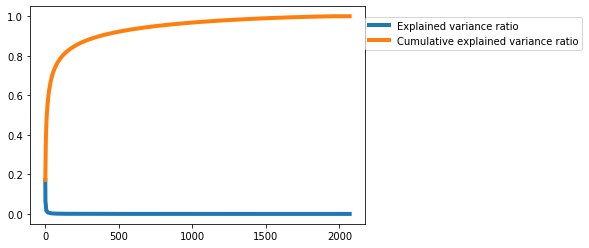

In [13]:
plt.plot(pca.explained_variance_ratio_, lw=4, label='Explained variance ratio')
plt.plot(np.cumsum(pca.explained_variance_ratio_), lw=4,
         label='Cumulative explained variance ratio')
plt.legend(loc=(1, 0.8))
plt.show()

In [14]:
X_train_pca.shape

(2071, 2071)

## Logistic Regression

In [15]:
#Set up model
model = LogisticRegression(solver='lbfgs', multi_class='ovr', n_jobs=-1, verbose = 1)

In [16]:
#Cross-validate, fit, train score, test score.
model, mean_cv_score, train_score, test_score, model_time=\
modelling_process(model, X_train_pca, train_labels, X_test_pca, test_labels)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


CV score:  [0.46506024 0.51449275 0.48792271 0.46135266 0.43478261]
Mean cv score:  0.4727221931203073
Train score:  1.0
Test score:  0.46332046332046334


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s finished


In [17]:
#Documentation
notes = 'PCA used - all components used for modelling'
temp_model_summary = model_documentation(temp_model_summary, model, 
                                         breed_list, len(train_images), 
                                         train_images[0].shape,
                                         clean, threshold,
                                         baseline, mean_cv_score,
                                         train_score, test_score, 
                                         model_time, notes)

baseline_score                                                   0.405405
dog_breeds                     [labrador, cocker_spaniel, french_bulldog]
model                                                                 NaN
model_parameters        {'C': 1.0, 'class_weight': None, 'dual': False...
model_type              <class 'sklearn.linear_model.logistic.Logistic...
notes                        PCA used - all components used for modelling
number_dog_breeds                                                       3
picture_quality                                                        30
picture_resolution                                          (400, 400, 3)
pictures_masked                                                         y
test_score                                                        0.46332
time_taken                                                         14.341
train_score                                                             1
training_sample_size                  

In [18]:
temp_model_summary

,baseline_score,dog_breeds,model,model_parameters,model_type,notes,number_dog_breeds,picture_quality,picture_resolution,pictures_masked,test_score,time_taken,train_score,training_sample_size,validation_score
0,0.405405,"[labrador, cocker_spaniel, french_bulldog]",NaN,"{'C': 1.0, 'class_weight': None, 'dual': False...",<class 'sklearn.linear_model.logistic.Logistic...,PCA used - all components used for modelling,3,30,"(400, 400, 3)",y,0.46332,14.341028,1.0,2071,0.472722


## Logistic RegressionCV

In [19]:
model = LogisticRegressionCV(Cs = 10, solver='lbfgs', multi_class='ovr', cv = 5,
                                  n_jobs=-1, verbose = 1)

In [20]:
#Cross-validate, fit, train score, test score.
start_time = time.time()
mean_cv_score = None
model.fit(X_train_pca, train_labels)
train_score = model.score(X_train_pca, train_labels)
print(train_score)
test_score = model.score(X_test_pca, test_labels)
print(test_score)
model_time = time.time() - start_time

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   45.0s finished


0.7107677450507002
0.5212355212355212


In [21]:
model.Cs_

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [22]:
model.C_

array([0.0001, 0.0001, 0.0001])

In [23]:
#Try with different values of Cs
C_list = np.logspace(-10,-1,10)
C_list

array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01])

In [24]:
model = LogisticRegressionCV(C_list, solver='lbfgs', multi_class='ovr', cv = 5,
                                  n_jobs=-1, verbose = 1)

In [25]:
#Cross-validate, fit, train score, test score.
start_time = time.time()
mean_cv_score = None
model.fit(X_train_pca, train_labels)
train_score = model.score(X_train_pca, train_labels)
print(train_score)
test_score = model.score(X_test_pca, test_labels)
print(test_score)
model_time = time.time() - start_time

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   20.9s finished


0.7107677450507002
0.5212355212355212


In [26]:
model.C_

array([0.0001, 0.0001, 0.0001])

In [27]:
#Best Cs within range of overall list of Cs => document as best example of LRCV
#Documentation
notes = 'PCA used - all components used for modelling'
temp_model_summary = model_documentation(temp_model_summary, model, 
                                         breed_list, len(train_images), 
                                         train_images[0].shape,
                                         clean, threshold,
                                         baseline, mean_cv_score,
                                         train_score, test_score, 
                                         model_time, notes)

baseline_score                                                   0.405405
dog_breeds                     [labrador, cocker_spaniel, french_bulldog]
model                                                                 NaN
model_parameters        {'Cs': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-...
model_type              <class 'sklearn.linear_model.logistic.Logistic...
notes                        PCA used - all components used for modelling
number_dog_breeds                                                       3
picture_quality                                                        30
picture_resolution                                          (400, 400, 3)
pictures_masked                                                         y
test_score                                                       0.521236
time_taken                                                          21.23
train_score                                                      0.710768
training_sample_size                  

## Random Forest Classifier

In [28]:
#Models are likely to be weak so progress to a Random Forest Classifier 
#rather than single decision tree.
#Use guidelines of problem with p features, use 
#sqrt(p) features in each split for a classification problem. Default setting for RFC kwa
#max_features, also achieved through 'auto'.
model = RandomForestClassifier(n_estimators = 2000,
                                   max_depth = 40, n_jobs=-1, 
                                   random_state = 1, verbose = 1,
                                   class_weight='balanced',
                                   max_features = 'auto')

In [29]:
#Cross-validate, fit, train score, test score.
model, mean_cv_score, train_score, test_score, model_time=\
modelling_process(model, X_train_pca, train_labels, X_test_pca, test_labels)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   17.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paral

CV score:  [0.43855422 0.5        0.4468599  0.49033816 0.48067633]
Mean cv score:  0.4712857226005471


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   24.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Do

Train score:  1.0


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s


Test score:  0.4806949806949807


[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    0.3s finished


In [30]:
#Grid search for better parameters
GS_params = {'n_estimators': [1500, 2000, 2500],
                'max_depth': [10, 20, 40, 60, 80]}
model4GS = RandomForestClassifier(n_jobs = -1, verbose = 1, random_state = 1)
model = GridSearchCV(model4GS, GS_params, cv = 5, n_jobs = -1, verbose = 1)

In [31]:
#Cross-validate, fit, train score, test score.
model, mean_cv_score, train_score, test_score, model_time=\
modelling_process_GS(model, X_train_pca, train_labels, X_test_pca, test_labels)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 21.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   29.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1

Mean cv score:  0.4823756639304684


[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 2500 out of 2500 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s


Train score:  0.9995171414775471


[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.4s


Test score:  0.47876447876447875


[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 2500 out of 2500 | elapsed:    0.5s finished


In [32]:
model.best_params_

{'max_depth': 20, 'n_estimators': 2500}

In [33]:
#Use higher number of n_esimators to see if better scores can be achieved
GS_params = {'n_estimators': [2500, 3000, 3500, 4000],
                'max_depth': [20]}
model4GS = RandomForestClassifier(n_jobs = -1, verbose = 1, random_state = 1)
model = GridSearchCV(model4GS, GS_params, cv = 5, n_jobs = -1, verbose = 1)

In [34]:
#Cross-validate, fit, train score, test score.
model, mean_cv_score, train_score, test_score, model_time=\
modelling_process_GS(model, X_train_pca, train_labels, X_test_pca, test_labels)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  9.8min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   31.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Mean cv score:  0.4857556735876388


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 3000 out of 3000 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


Train score:  0.9995171414775471


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.4s


Test score:  0.4806949806949807


[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 3000 out of 3000 | elapsed:    0.6s finished


In [35]:
model.best_params_

{'max_depth': 20, 'n_estimators': 3000}

In [36]:
#Best parameters are within range of parameters so conclude modelling.
#Documentation
notes = 'PCA used - all components used for modelling'
temp_model_summary = model_documentation(temp_model_summary, model, 
                                         breed_list, len(train_images), 
                                         train_images[0].shape,
                                         clean, threshold,
                                         baseline, mean_cv_score,
                                         train_score, test_score, 
                                         model_time, notes)

baseline_score                                                   0.405405
dog_breeds                     [labrador, cocker_spaniel, french_bulldog]
model                                                                 NaN
model_parameters        {'cv': 5, 'error_score': 'raise-deprecating', ...
model_type              <class 'sklearn.model_selection._search.GridSe...
notes                        PCA used - all components used for modelling
number_dog_breeds                                                       3
picture_quality                                                        30
picture_resolution                                          (400, 400, 3)
pictures_masked                                                         y
test_score                                                       0.480695
time_taken                                                         622.54
train_score                                                      0.999517
training_sample_size                  

## NaiveBayes

In [37]:
model = GaussianNB()

In [38]:
#Cross-validate, fit, train score, test score.
model, mean_cv_score, train_score, test_score, model_time=\
modelling_process(model, X_train_pca, train_labels, X_test_pca, test_labels)

CV score:  [0.34939759 0.36714976 0.35024155 0.36231884 0.39371981]
Mean cv score:  0.36456550841045343
Train score:  0.40077257363592467
Test score:  0.3745173745173745


In [39]:
#Documentation
notes = 'PCA used - all components used for modelling'
temp_model_summary = model_documentation(temp_model_summary, model, 
                                         breed_list, len(train_images), 
                                         train_images[0].shape,
                                         clean, threshold,
                                         baseline, mean_cv_score,
                                         train_score, test_score, 
                                         model_time, notes)

baseline_score                                              0.405405
dog_breeds                [labrador, cocker_spaniel, french_bulldog]
model                                                            NaN
model_parameters            {'priors': None, 'var_smoothing': 1e-09}
model_type                  <class 'sklearn.naive_bayes.GaussianNB'>
notes                   PCA used - all components used for modelling
number_dog_breeds                                                  3
picture_quality                                                   30
picture_resolution                                     (400, 400, 3)
pictures_masked                                                    y
test_score                                                  0.374517
time_taken                                                  0.764193
train_score                                                 0.400773
training_sample_size                                            2071
validation_score                  

## Gradient Boosting Classifier

In [40]:
#Start with basic model with no tuned parameters
model = GradientBoostingClassifier(verbose=1, random_state = 1, max_features = 'sqrt')

In [41]:
#Cross-validate, fit, train score, test score.
model, mean_cv_score, train_score, test_score, model_time=\
modelling_process(model, X_train_pca, train_labels, X_test_pca, test_labels)

      Iter       Train Loss   Remaining Time 
         1        1744.4417            2.60s
         2        1723.8141            2.34s
         3        1702.0101            2.28s
         4        1683.4717            2.21s
         5        1663.1652            2.18s
         6        1646.2873            2.15s
         7        1629.6208            2.12s
         8        1612.1233            2.09s
         9        1596.0915            2.06s
        10        1578.9264            2.06s
        20        1429.1024            1.81s
        30        1310.4012            1.58s
        40        1209.8126            1.37s
        50        1111.3193            1.14s
        60        1027.3293            0.91s
        70         952.5637            0.68s
        80         885.5163            0.45s
        90         820.4187            0.22s
       100         765.2531            0.00s
      Iter       Train Loss   Remaining Time 
         1        1753.4381            2.37s
        

In [42]:
model.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)>

Tune parameters - following this guide:
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

- learning rate - use default of 0.1
- number of tress - range of 40-80 suggested so gridsearch over this first.
- min_samples_split = suggested 0.5-1% of total values, here fitting 2600 images so range is 13-26, use 20 as mid-point.
- min_samples_leaf - use 10% of min_samples_split
- max_depth - suggested range of 5-8. Use 5 given number of images.
- max_features = 'sqrt'
- subsample = 0.8

In [43]:
model4GS = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 50,
                                      min_samples_split = 20, min_samples_leaf= 2,
                                      max_features = 'sqrt', max_depth = 5, 
                                      subsample = 0.8, verbose=1, random_state = 1)
GS_params = {'n_estimators': range(20,81,10)}
model = GridSearchCV(model4GS, GS_params, cv = 5, n_jobs = -1, verbose = 1)

In [44]:
#Cross-validate, fit, train score, test score.
model, mean_cv_score, train_score, test_score, model_time=\
modelling_process_GS(model, X_train_pca, train_labels, X_test_pca, test_labels)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   16.3s finished


      Iter       Train Loss      OOB Improve   Remaining Time 
         1        1720.4158           4.0261            2.86s
         2        1677.3143           1.8971            2.67s
         3        1648.2679           0.5843            2.62s
         4        1612.2026           1.4859            2.57s
         5        1584.9284           1.5658            2.51s
         6        1562.0634           1.2055            2.48s
         7        1521.5848           0.0139            2.42s
         8        1491.6302           1.5913            2.38s
         9        1463.2298          -0.0581            2.33s
        10        1433.3963           1.0026            2.30s
        20        1182.2741           0.3189            1.90s
        30        1011.1351           0.3123            1.51s
        40         851.5838           0.9035            1.13s
        50         738.2835           0.0584            0.75s
        60         636.9716          -0.2341            0.37s
       

In [45]:
model.best_params_

{'n_estimators': 70}

Best value for n_estimators = 70

Now look at tree-specific parameters, particularly:
- max_depth = 3 to 7
- min_samples_split = 8 to 40

In [46]:
model4GS = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 70,
                                      min_samples_split = 20, min_samples_leaf= 2,
                                      max_features = 'sqrt', max_depth = 5, 
                                      subsample = 0.8, verbose=1, random_state = 1)
GS_params = {'max_depth': range(3,8,1),
            'min_samples_split': range(8, 41, 8)}
model = GridSearchCV(model4GS, GS_params, cv = 5, n_jobs = -1, verbose = 1)

In [47]:
#Cross-validate, fit, train score, test score.
model, mean_cv_score, train_score, test_score, model_time=\
modelling_process_GS(model, X_train_pca, train_labels, X_test_pca, test_labels)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  1.5min finished


      Iter       Train Loss      OOB Improve   Remaining Time 
         1        1714.2778           2.8175            4.38s
         2        1654.7279           1.3431            4.51s
         3        1620.7362           0.9994            4.43s
         4        1577.1658           1.4425            4.23s
         5        1538.2588           2.3715            4.12s
         6        1508.5378           1.4506            4.05s
         7        1470.3898           0.0020            3.94s
         8        1438.2598           1.0849            3.88s
         9        1410.4157           0.5854            3.79s
        10        1384.5110           1.5211            3.71s
        20        1102.5970           0.7198            3.06s
        30         899.6630          -1.3439            2.41s
        40         725.0159           0.1895            1.78s
        50         604.1470           0.1791            1.16s
        60         501.1581          -0.6399            0.56s
       

In [48]:
model.best_params_,

({'max_depth': 6, 'min_samples_split': 40},)

In [49]:
#Min_samples at maximum range value => Extend range:
GS_params = {'max_depth': [6],
            'min_samples_split': range(40, 73, 8)}
model = GridSearchCV(model4GS, GS_params, cv = 5, n_jobs = -1, verbose = 1)

In [50]:
#Cross-validate, fit, train score, test score.
model, mean_cv_score, train_score, test_score, model_time=\
modelling_process_GS(model, X_train_pca, train_labels, X_test_pca, test_labels)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   18.9s finished


      Iter       Train Loss      OOB Improve   Remaining Time 
         1        1714.2778           2.8175            3.17s
         2        1654.7279           1.3431            3.15s
         3        1620.7362           0.9994            3.08s
         4        1577.1658           1.4425            3.00s
         5        1538.2588           2.3715            3.10s
         6        1508.5378           1.4506            3.10s
         7        1470.3898           0.0020            3.06s
         8        1438.2598           1.0849            3.04s
         9        1410.4157           0.5854            3.00s
        10        1384.5110           1.5211            2.97s
        20        1102.5970           0.7198            2.52s
        30         899.6630          -1.3439            1.99s
        40         725.0159           0.1895            1.47s
        50         604.1470           0.1791            0.96s
        60         501.1581          -0.6399            0.47s
       

In [51]:
model.best_params_,

({'max_depth': 6, 'min_samples_split': 40},)

One more round of grid-searching to see if better results can be achieved bu tuning best parameter for max_features. Currently using sqrt features - limit to range around the square root of features, being sqrt(2071) = 45, so 30 - 60 in intervals of 5.

In [52]:
model4GS = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 70,
                                      min_samples_split = 40, min_samples_leaf= 2,
                                      max_features = 'sqrt', max_depth = 6, 
                                      subsample = 0.8, verbose=1, random_state = 1)
GS_params = {'max_features': range(30,61,5)}
model = GridSearchCV(model4GS, GS_params, cv = 5, n_jobs = -1, verbose = 1)

In [53]:
#Cross-validate, fit, train score, test score.
model, mean_cv_score, train_score, test_score, model_time=\
modelling_process_GS(model, X_train_pca, train_labels, X_test_pca, test_labels)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   24.5s finished


      Iter       Train Loss      OOB Improve   Remaining Time 
         1        1712.0130           0.8019            4.13s
         2        1656.6251           3.2156            4.01s
         3        1617.3262           2.0330            3.88s
         4        1577.2271           2.6722            3.86s
         5        1537.5197           0.8023            3.77s
         6        1500.0603           1.4557            3.72s
         7        1465.7470           0.5373            3.62s
         8        1430.6631           1.4692            3.59s
         9        1389.7081           2.3573            3.56s
        10        1360.2712           0.5102            3.50s
        20        1053.0453           0.1870            2.92s
        30         871.4671           0.3127            2.30s
        40         705.1654          -0.5624            1.72s
        50         579.5745           0.3795            1.15s
        60         491.5093          -0.2316            0.59s
       

In [54]:
model.best_params_,

({'max_features': 60},)

In [55]:
#60 is max of range => extend range:
model4GS = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 70,
                                      min_samples_split = 40, min_samples_leaf= 2,
                                      max_features = 'sqrt', max_depth = 6, 
                                      subsample = 0.8, verbose=1, random_state = 1)
GS_params = {'max_features': range(60,91,5)}
model = GridSearchCV(model4GS, GS_params, cv = 5, n_jobs = -1, verbose = 1)

In [56]:
#Cross-validate, fit, train score, test score.
model, mean_cv_score, train_score, test_score, model_time=\
modelling_process_GS(model, X_train_pca, train_labels, X_test_pca, test_labels)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   40.7s finished


      Iter       Train Loss      OOB Improve   Remaining Time 
         1        1712.0130           0.8019            4.65s
         2        1656.6251           3.2156            4.34s
         3        1617.3262           2.0330            4.14s
         4        1577.2271           2.6722            4.08s
         5        1537.5197           0.8023            4.02s
         6        1500.0603           1.4557            3.97s
         7        1465.7470           0.5373            3.88s
         8        1430.6631           1.4692            3.84s
         9        1389.7081           2.3573            3.76s
        10        1360.2712           0.5102            3.70s
        20        1053.0453           0.1870            3.08s
        30         871.4671           0.3127            2.44s
        40         705.1654          -0.5624            1.82s
        50         579.5745           0.3795            1.21s
        60         491.5093          -0.2316            0.60s
       

In [57]:
model.best_params_

{'max_features': 60}

In [58]:
#Documentation of best Gradient Boosting model.
notes = 'PCA used. Gradient Boosting max_features tuned to 60'
temp_model_summary = model_documentation(temp_model_summary, model, 
                                         breed_list, len(train_images), 
                                         train_images[0].shape,
                                         clean, threshold,
                                         baseline, mean_cv_score,
                                         train_score, test_score, 
                                         model_time, notes)

baseline_score                                                   0.405405
dog_breeds                     [labrador, cocker_spaniel, french_bulldog]
model                                                                 NaN
model_parameters        {'cv': 5, 'error_score': 'raise-deprecating', ...
model_type              <class 'sklearn.model_selection._search.GridSe...
notes                   PCA used. Gradient Boosting max_features tuned...
number_dog_breeds                                                       3
picture_quality                                                        30
picture_resolution                                          (400, 400, 3)
pictures_masked                                                         y
test_score                                                       0.484556
time_taken                                                        45.2807
train_score                                                      0.998551
training_sample_size                  

## Support Vector Machines

In [59]:
#Start with basic model with no tuned parameters
model = SVC(kernel = 'rbf', gamma = 'scale')

In [60]:
#Cross-validate, fit, train score, test score.
model, mean_cv_score, train_score, test_score, model_time=\
modelling_process(model, X_train_pca, train_labels, X_test_pca, test_labels)

CV score:  [0.53012048 0.59903382 0.5410628  0.57729469 0.54589372]
Mean cv score:  0.5586811012164601
Train score:  0.858522452921294
Test score:  0.583011583011583


### GS RBF kernel

In [61]:
#Now tune with GridSearch:
#scale default is equal to 1/(n_features * X.var)
n_features = X_train_pca.shape[1]
print(n_features)
X_var = X_train_pca.var()
print(X_var)
scale = 1 / (n_features * X_var)
print (scale)

2071
11.235309617824552
4.2976877262632596e-05


In [62]:
gamma_range = list(np.logspace(-8,-2, 7))

In [63]:
model4GS = SVC(kernel = 'rbf')
GS_params = {'C': [1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0],
                   'gamma': gamma_range}
model = GridSearchCV(model4GS, GS_params, cv = 5, n_jobs = -1, verbose = 1)

In [64]:
#Cross-validate, fit, train score, test score.
model, mean_cv_score, train_score, test_score, model_time=\
modelling_process_GS(model, X_train_pca, train_labels, X_test_pca, test_labels)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed: 10.3min finished


Mean cv score:  0.5760502172863351
Train score:  0.9971028488652824
Test score:  0.581081081081081


In [65]:
model.best_params_

{'C': 2.75, 'gamma': 0.0001}

### GS Linear kernel

In [66]:
#Parameters within range. Now try linear kernel.
model4GS = SVC(kernel = 'linear', gamma = 'scale')
gamma_range = list(np.logspace(-8,-2, 7))
GS_params = {'C': [1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0],
            'gamma': gamma_range}
model = GridSearchCV(model4GS, GS_params, cv = 5, n_jobs = -1, verbose = 1)

In [67]:
#Cross-validate, fit, train score, test score.
model, mean_cv_score, train_score, test_score, model_time=\
modelling_process_GS(model, X_train_pca, train_labels, X_test_pca, test_labels)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  9.3min finished


Mean cv score:  0.47223563495895704
Train score:  1.0
Test score:  0.47104247104247104


In [68]:
model.best_params_

{'C': 1.5, 'gamma': 1e-08}

In [69]:
#Both C and gamma at lower end - Try lower values:
gamma_range = list(np.logspace(-14, -8, 7))
C_range = list(np.logspace(-6, 0, 7))
GS_params = {'C': C_range,
            'gamma': gamma_range}
model = GridSearchCV(model4GS, GS_params, cv = 5, n_jobs = -1, verbose = 1)

In [70]:
#Cross-validate, fit, train score, test score.
model, mean_cv_score, train_score, test_score, model_time=\
modelling_process_GS(model, X_train_pca, train_labels, X_test_pca, test_labels)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  8.9min finished


Mean cv score:  0.49975857073877356
Train score:  0.7518107194591984
Test score:  0.5096525096525096


In [72]:
model.best_params_, model.cv_results_

({'C': 0.0001, 'gamma': 1e-14},
 {'mean_fit_time': array([14.84344172, 14.41145535, 13.80787029, 15.58044143, 15.90765824,
         14.78854699, 14.52324743, 14.08135815, 15.40637922, 14.95179305,
         13.9712152 , 13.93472142, 14.01982646, 14.72223191, 13.42196422,
         12.75593653, 12.7821074 , 13.42884459, 14.32524462, 13.13277593,
         12.79925003, 14.34363523, 14.30427012, 13.986131  , 14.21492596,
         14.12732377, 13.90647855, 14.11188726, 13.87376575, 13.93934565,
         13.99527302, 13.68930354, 13.93933015, 13.78710876, 13.72888889,
         13.84584961, 13.56287932, 13.84492354, 13.67680483, 13.66750727,
         13.74380078, 13.52479248, 13.75862718, 13.82662196, 13.83120222,
         14.06136527, 13.72292824, 13.85772333, 10.57589512]),
  'std_fit_time': array([0.14332244, 0.51275144, 0.1697977 , 0.96372564, 0.52628506,
         0.13922676, 0.27706851, 0.13078167, 0.16872234, 0.71248379,
         0.0738397 , 0.13956635, 0.36777522, 0.10066197, 0.67572771,

In [73]:
#C in range, gamma at lower range but has same cv score as other gamma values.
#No material improvement in results vs rbf kernel - move on to polynomial kernel.

### GS polynomial kernel

In [76]:
model4GS = SVC(kernel = 'poly', gamma = 'scale')
gamma_range = list(np.logspace(-8,-2, 7))
GS_params = {'C': [2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0],
            'degree': [2, 3, 4, 5, 6],
            'gamma': gamma_range}
model = GridSearchCV(model4GS, GS_params, cv = 5, n_jobs = -1, verbose = 1)

In [75]:
#Cross-validate, fit, train score, test score.
model, mean_cv_score, train_score, test_score, model_time=\
modelling_process_GS(model, X_train_pca, train_labels, X_test_pca, test_labels)

Fitting 5 folds for each of 245 candidates, totalling 1225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 30.9min
[Parallel(n_jobs=-1)]: Done 1225 out of 1225 | elapsed: 50.0min finished


Mean cv score:  0.5499758570738773
Train score:  0.9961371318203767
Test score:  0.5328185328185329


### Model documentation

In [77]:
#No significant increase over tuned rbf model => rerun rbf for model documentation:
model = SVC(kernel = 'rbf', C= 2.75, gamma = 0.0001)
model, mean_cv_score, train_score, test_score, model_time=\
modelling_process(model, X_train_pca, train_labels, X_test_pca, test_labels)

CV score:  [0.5686747  0.61352657 0.53140097 0.6352657  0.53140097]
Mean cv score:  0.5760537803387463
Train score:  0.9971028488652824
Test score:  0.581081081081081


In [78]:
notes = 'PCA used. Grid Search tuned'
temp_model_summary = model_documentation(temp_model_summary, model, 
                                         breed_list, len(train_images), 
                                         train_images[0].shape,
                                         clean, threshold,
                                         baseline, mean_cv_score,
                                         train_score, test_score, 
                                         model_time, notes)

baseline_score                                                   0.405405
dog_breeds                     [labrador, cocker_spaniel, french_bulldog]
model                                                                 NaN
model_parameters        {'C': 2.75, 'cache_size': 200, 'class_weight':...
model_type                              <class 'sklearn.svm.classes.SVC'>
notes                                         PCA used. Grid Search tuned
number_dog_breeds                                                       3
picture_quality                                                        30
picture_resolution                                          (400, 400, 3)
pictures_masked                                                         y
test_score                                                       0.581081
time_taken                                                        80.2374
train_score                                                      0.997103
training_sample_size                  

## Save results to model summary dataframe

In [79]:
temp_model_summary

,baseline_score,dog_breeds,model,model_parameters,model_type,notes,number_dog_breeds,picture_quality,picture_resolution,pictures_masked,test_score,time_taken,train_score,training_sample_size,validation_score
0,0.405405,"[labrador, cocker_spaniel, french_bulldog]",NaN,"{'C': 1.0, 'class_weight': None, 'dual': False...",<class 'sklearn.linear_model.logistic.Logistic...,PCA used - all components used for modelling,3,30,"(400, 400, 3)",y,0.463320,14.341028,1.000000,2071,0.472722
1,0.405405,"[labrador, cocker_spaniel, french_bulldog]",NaN,"{'Cs': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-...",<class 'sklearn.linear_model.logistic.Logistic...,PCA used - all components used for modelling,3,30,"(400, 400, 3)",y,0.521236,21.230026,0.710768,2071,None
2,0.405405,"[labrador, cocker_spaniel, french_bulldog]",NaN,"{'cv': 5, 'error_score': 'raise-deprecating', ...",<class 'sklearn.model_selection._search.GridSe...,PCA used - all components used for modelling,3,30,"(400, 400, 3)",y,0.480695,622.540029,0.999517,2071,0.485756
3,0.405405,"[labrador, cocker_spaniel, french_bulldog]",NaN,"{'priors': None, 'var_smoothing': 1e-09}",<class 'sklearn.naive_bayes.GaussianNB'>,PCA used - all components used for modelling,3,30,"(400, 400, 3)",y,0.374517,0.764193,0.400773,2071,0.364566
4,0.405405,"[labrador, cocker_spaniel, french_bulldog]",NaN,"{'cv': 5, 'error_score': 'raise-deprecating', ...",<class 'sklearn.model_selection._search.GridSe...,PCA used. Gradient Boosting max_features tuned...,3,30,"(400, 400, 3)",y,0.484556,45.280651,0.998551,2071,0.50507
5,0.405405,"[labrador, cocker_spaniel, french_bulldog]",NaN,"{'C': 2.75, 'cache_size': 200, 'class_weight':...",<class 'sklearn.svm.classes.SVC'>,PCA used. Grid Search tuned,3,30,"(400, 400, 3)",y,0.581081,80.237442,0.997103,2071,0.576054


In [80]:
temp_model_summary.to_pickle('model_summary_clean_pics_simple_modelling_3_breeds_1.pkl')

In [86]:
model_summary = pd.read_pickle('model_summary.pkl')

In [87]:
model_summary.head()

,baseline_score,dog_breeds,model,model_parameters,model_type,notes,number_dog_breeds,picture_quality,picture_resolution,pictures_masked,test_score,time_taken,train_score,training_sample_size,validation_score
8,0.405405,"[labrador, cocker_spaniel, french_bulldog]",NN model 1,"Model: ""sequential""\n_________________________...",<class 'tensorflow.python.keras.engine.sequent...,NN model 1,3,30,"(400, 400, 3)",y,0.409266,297.814807,0.927536,2071,0.455422
9,0.405405,"[labrador, cocker_spaniel, french_bulldog]",CNN model 1,"Model: ""sequential_2""\n_______________________...",<class 'tensorflow.python.keras.engine.sequent...,CNN model 1,3,30,"(400, 400, 3)",y,0.544402,696.484920,0.916667,2071,0.551807
10,0.405405,"[labrador, cocker_spaniel, french_bulldog]",CNN model 2,"Model: ""sequential_4""\n_______________________...",<class 'tensorflow.python.keras.engine.sequent...,CNN model 2,3,30,"(400, 400, 3)",y,0.538610,696.484920,0.916667,2071,0.551807
11,0.405405,"[labrador, cocker_spaniel, french_bulldog]",CNN model 3 - added drop outs,"Model: ""sequential_5""\n_______________________...",<class 'tensorflow.python.keras.engine.sequent...,CNN model 3 - added drop outs,3,30,"(400, 400, 3)",y,0.565637,800.053933,0.762681,2071,0.551807
12,0.405405,"[labrador, cocker_spaniel, french_bulldog]",CNN model 4 - 2 extra layers,"Model: ""sequential_6""\n_______________________...",<class 'tensorflow.python.keras.engine.sequent...,CNN model 4 - 2 extra layers,3,30,"(400, 400, 3)",y,0.621622,1144.334881,0.680556,2071,0.626506


In [88]:
model_summary.shape

(41, 15)

In [89]:
model_summary = model_summary.append(temp_model_summary, ignore_index=True)
model_summary.tail()

,baseline_score,dog_breeds,model,model_parameters,model_type,notes,number_dog_breeds,picture_quality,picture_resolution,pictures_masked,test_score,time_taken,train_score,training_sample_size,validation_score
42,0.405405,"[labrador, cocker_spaniel, french_bulldog]",NaN,"{'Cs': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-...",<class 'sklearn.linear_model.logistic.Logistic...,PCA used - all components used for modelling,3,30,"(400, 400, 3)",y,0.521236,21.230026,0.710768,2071,None
43,0.405405,"[labrador, cocker_spaniel, french_bulldog]",NaN,"{'cv': 5, 'error_score': 'raise-deprecating', ...",<class 'sklearn.model_selection._search.GridSe...,PCA used - all components used for modelling,3,30,"(400, 400, 3)",y,0.480695,622.540029,0.999517,2071,0.485756
44,0.405405,"[labrador, cocker_spaniel, french_bulldog]",NaN,"{'priors': None, 'var_smoothing': 1e-09}",<class 'sklearn.naive_bayes.GaussianNB'>,PCA used - all components used for modelling,3,30,"(400, 400, 3)",y,0.374517,0.764193,0.400773,2071,0.364566
45,0.405405,"[labrador, cocker_spaniel, french_bulldog]",NaN,"{'cv': 5, 'error_score': 'raise-deprecating', ...",<class 'sklearn.model_selection._search.GridSe...,PCA used. Gradient Boosting max_features tuned...,3,30,"(400, 400, 3)",y,0.484556,45.280651,0.998551,2071,0.50507
46,0.405405,"[labrador, cocker_spaniel, french_bulldog]",NaN,"{'C': 2.75, 'cache_size': 200, 'class_weight':...",<class 'sklearn.svm.classes.SVC'>,PCA used. Grid Search tuned,3,30,"(400, 400, 3)",y,0.581081,80.237442,0.997103,2071,0.576054


In [90]:
model_summary.to_pickle('model_summary.pkl')